## Методы обработки естественных языков

### Практическая работа 5

In [1]:
import re
import nltk
import spacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.sentiment import SentimentIntensityAnalyzer

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    Input,
    LSTM,
)
from tensorflow.keras.optimizers import RMSprop

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
CHAPTERS_NUM = 16
TOPICS_NUM = 4

In [4]:
!spacy download en_core_web_sm
!spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.4 MB/s  0:00:03m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 5.6 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [5]:
# import os

# def read_chapters(chapter_num):
#     chapters = []
#     for i in range(chapter_num):
#         filename = os.path.join("data", f"book_chapter_{i+1}.txt")
#         with open(filename, "r", encoding="utf-8") as f:
#             chapter_content = f.read()
#             chapters.append(chapter_content)
#     return chapters

# chapters = read_chapters(CHAPTERS_NUM)

In [6]:
def extract_book_from_gutenberg_ebook(text):
    m = re.search(
        r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*(.*?)\*\*\* END OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*",
        text,
        flags=re.DOTALL | re.IGNORECASE,
    )
    if m:
        return m.group(1).strip()
    return ""


def split_chapters_content(book_text):
    pattern = re.compile(
        r"(?m)^CHAPTER\s+[IVXLCDM]+\.\s*\n"
        r".*?\n"
        r"(.*?)(?=^CHAPTER\s+[IVXLCDM]+\.|\Z)",
        re.DOTALL,
    )
    chapters = [match.group(1).strip() for match in pattern.finditer(book_text)]
    return chapters


book_text = ""
with open("data/book.txt", "r") as f:
    book_text = f.read()

extracted_book = extract_book_from_gutenberg_ebook(book_text)
if extracted_book != "":
    book_text = extracted_book

chapters = split_chapters_content(book_text)

### Нормализация

In [7]:
nlp = spacy.load("en_core_web_sm")


def normalize_text(text):
    doc = nlp(text)
    lemmas = [
        token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop
    ]
    return " ".join(lemmas)


normalized_chapters = []
for i in range(len(chapters)):
    normalized_chapters.append(normalize_text(chapters[i]))
normalized_chapters16 = normalized_chapters[:CHAPTERS_NUM]

print("Главы книги после нормализации")
for i in range(CHAPTERS_NUM):
    print(f"    Глава {i + 1}: {normalized_chapters16[i][:20]}...")

Главы книги после нормализации
    Глава 1: obstinate north wind...
    Глава 2: observer close hand ...
    Глава 3: child remain motionl...
    Глава 4: kind band leave chil...
    Глава 5: seven evening wind d...
    Глава 6: child thing dumb won...
    Глава 7: run breathless rando...
    Глава 8: snowstorm mystery oc...
    Глава 9: hooker gulf portland...
    Глава 10: man board craft abso...
    Глава 11: old man chief band n...
    Глава 12: mist deform sort ine...
    Глава 13: grow preoccupation d...
    Глава 14: wild jubilee delight...
    Глава 15: characteristic snows...
    Глава 16: skipper helm burst b...


### Анализатор тональности

In [8]:
nltk.download("vader_lexicon", quiet=True)


def get_text_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound_score = scores["compound"]
    if compound_score >= 0.05:
        return "pos"
    elif compound_score <= -0.05:
        return "neg"
    else:
        return "neu"


labels_dict = {
    "neu": "нейтральную",
    "pos": "положительную",
    "neg": "отрицательную",
}

for i in range(CHAPTERS_NUM):
    print(
        f"Глава {i + 1} имеет {labels_dict[get_text_sentiment(normalized_chapters[i])]} тональность"
    )

Глава 1 имеет положительную тональность
Глава 2 имеет положительную тональность
Глава 3 имеет нейтральную тональность
Глава 4 имеет отрицательную тональность
Глава 5 имеет отрицательную тональность
Глава 6 имеет отрицательную тональность
Глава 7 имеет отрицательную тональность
Глава 8 имеет отрицательную тональность
Глава 9 имеет отрицательную тональность
Глава 10 имеет отрицательную тональность
Глава 11 имеет положительную тональность
Глава 12 имеет отрицательную тональность
Глава 13 имеет отрицательную тональность
Глава 14 имеет отрицательную тональность
Глава 15 имеет отрицательную тональность
Глава 16 имеет положительную тональность


### Векторизация

In [9]:
vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=2,
    max_features=1000,
    stop_words="english",
)
tfidf_model = vectorizer.fit_transform(normalized_chapters16)
feature_names = vectorizer.get_feature_names_out()
print(f"10 признаков из матрицы TF-IDF: {', '.join(feature_names[:10])}")

10 признаков из матрицы TF-IDF: aback, abaft, abandon, abrupt, absolutely, absorb, abyss, accept, acceptance, accomplice


### LSA

In [10]:
def print_heatmap(matrix):
    labels = [f"Глава {i + 1}" for i in range(CHAPTERS_NUM)]
    plt.figure(figsize=(16, 8))
    sns.heatmap(
        matrix,
        xticklabels=labels,
        yticklabels=labels,
        cmap="Greys",
        annot=True,
        fmt=".2f",
        square=True,
    )
    plt.title("Тепловая карта семантической близости глав")
    plt.xticks(rotation=45)
    plt.show()

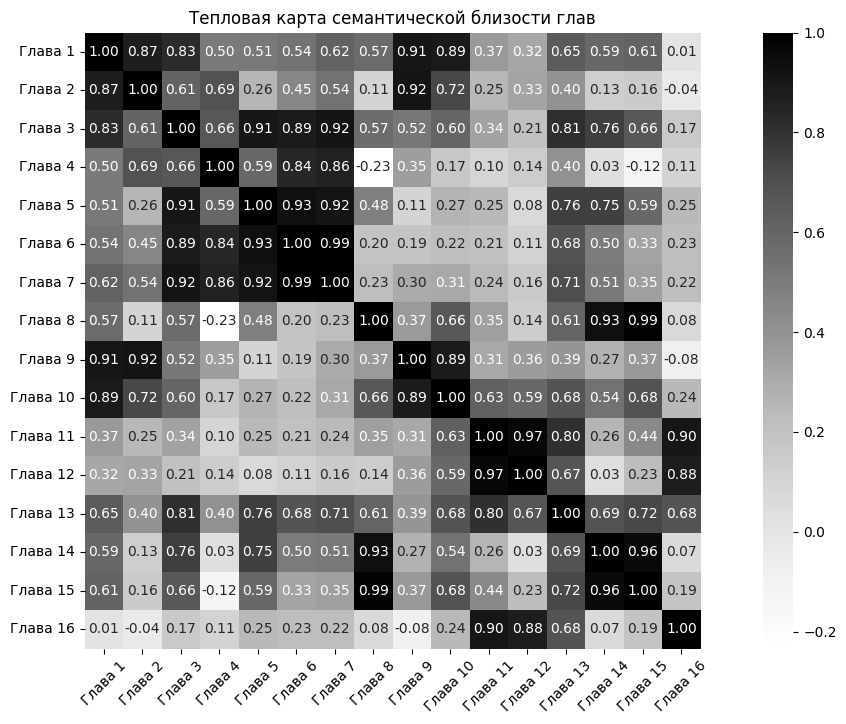

In [11]:
lsa = TruncatedSVD(n_components=TOPICS_NUM, random_state=0)
lsa_model = lsa.fit_transform(tfidf_model)

similarity_matrix = cosine_similarity(lsa_model)
print_heatmap(similarity_matrix)

Можно заметить, что первые 7 глав имеют высокую семантическую близость друг с другом.\
Также глава под номером 13 является наиболее схожей с остальными главами, чем другие.

In [12]:
n_words = 5
print(f"Список из {n_words} самых значимых слов в теме")
for i, topic in enumerate(lsa.components_):
    idxs = topic.argsort()[-n_words:][::-1]
    print(f"    Тема {i + 1}: {', '.join([feature_names[idx] for idx in idxs])}")

Список из 5 самых значимых слов в теме
    Тема 1: child, hooker, wave, doctor, time
    Тема 2: child, gibbet, corpse, plain, chain
    Тема 3: child, basque, doctor, skipper, time
    Тема 4: bell, doctor, child, skipper, chain


### Doc2Vec

In [13]:
tagged_data = [
    TaggedDocument(words=doc.split(" "), tags=[f"DOC_{i}"])
    for i, doc in enumerate(normalized_chapters16)
]

In [14]:
doc2vec_model = Doc2Vec(min_count=2, epochs=32, dm=0, workers=4, seed=0)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(
    tagged_data,
    total_examples=doc2vec_model.corpus_count,
    epochs=doc2vec_model.epochs,
)
doc2vec_vectors = np.array(
    [doc2vec_model.dv[f"DOC_{i}"] for i in range(len(normalized_chapters16))]
)

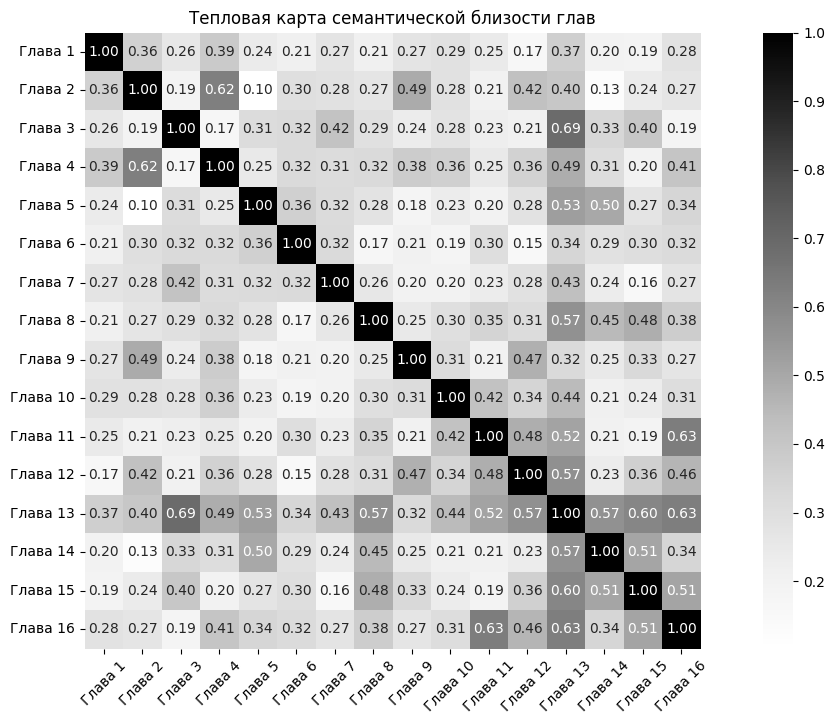

In [15]:
doc2vec_similarity = cosine_similarity(doc2vec_vectors)
print_heatmap(doc2vec_similarity)

Можно заметить, что главы (2 и 4), (3 и 13), (11 и 16) имеют друг с другом высокую семантическую близость.\
Также глава под номером 13 является наиболее схожей с остальными главами, чем другие (как и в *LSA*)

### Word2Vec

In [16]:
sentences = [doc.split(" ") for doc in normalized_chapters]
word2vec_model = Word2Vec(
    sentences=sentences,
    seed=0,
    sg=1,
    epochs=100,
)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [17]:
# user_input = input(
#     "Введите слова, схожесть которых " \
#     "Вы хотите увидеть (слова должны быть на английском языке)"
# ).split(',')
# if user_input == [""]:
#     user_input = [w for w in word2vec_model.wv.key_to_index if len(w) > 3][:5]
user_input = ["english", "spanish", "latin"]

In [18]:
print("Семантически похожие слова:")
for word in user_input:
    word = word.lower()
    try:
        similar_words = word2vec_model.wv.most_similar(word, topn=10)
        print(f"    {word}: {', '.join([s[0] for s in similar_words])}")
    except KeyError:
        print(f"    {word}: нет похожих слов:(")

Семантически похожие слова:
    english: danish, norman, german, seventeenth, denmark, prize, roman, spanish, island, explanation
    spanish: french, venetian, basque, english, poetry, sailor, germany, italian, osborne, islands
    latin: music, include, representation, numerous, teach, frequently, middle, tender, elizabeth, jussu


### CNN

In [19]:
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 264

normalized_chapters32 = normalized_chapters[:32]

In [20]:
sentiments = [get_text_sentiment(t) for t in normalized_chapters32]

le = LabelEncoder()
y = le.fit_transform(sentiments)

num_classes = len(le.classes_)

y = to_categorical(y, num_classes=num_classes)

In [21]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_chapters32)
sequences = tokenizer.texts_to_sequences(normalized_chapters32)
word_index = tokenizer.word_index

In [22]:
x = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post",
)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [23]:
embedding_dim = word2vec_model.vector_size
vocab_size = min(len(word_index) + 1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for w, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [24]:
model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
    )
)
model.add(Conv1D(128, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

In [25]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [26]:
history = model.fit(
    x_train,
    y_train,
    epochs=8,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/8
1/1 - 1s - 1s/step - accuracy: 0.1667 - loss: 1.6760 - val_accuracy: 0.7500 - val_loss: 0.8862
Epoch 2/8
1/1 - 0s - 46ms/step - accuracy: 0.6250 - loss: 0.9453 - val_accuracy: 0.7500 - val_loss: 0.7682
Epoch 3/8
1/1 - 0s - 45ms/step - accuracy: 0.7083 - loss: 0.7901 - val_accuracy: 0.7500 - val_loss: 0.7696
Epoch 4/8
1/1 - 0s - 45ms/step - accuracy: 0.7083 - loss: 0.7326 - val_accuracy: 0.7500 - val_loss: 0.7898
Epoch 5/8
1/1 - 0s - 45ms/step - accuracy: 0.7083 - loss: 0.7071 - val_accuracy: 0.7500 - val_loss: 0.8186
Epoch 6/8
1/1 - 0s - 45ms/step - accuracy: 0.7917 - loss: 0.5993 - val_accuracy: 0.7500 - val_loss: 0.8585
Epoch 7/8
1/1 - 0s - 46ms/step - accuracy: 0.7083 - loss: 0.6647 - val_accuracy: 0.7500 - val_loss: 0.9067
Epoch 8/8
1/1 - 0s - 44ms/step - accuracy: 0.7083 - loss: 0.7108 - val_accuracy: 0.7500 - val_loss: 0.9510


In [27]:
_, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Точность определения тональности на тестовых данных: {accuracy:.3f}")

Точность определения тональности на тестовых данных: 0.750


### LSTM

Для генерации была взята книга целиком, без нормализации.

In [28]:
book_en = ""
with open("data/book_en.txt", "r", encoding="utf-8") as f:
    book_en = f.read().replace("\n", " ").replace("\r", " ")

book_ru = ""
with open("data/book_ru.txt", "r", encoding="utf-8") as f:
    book_ru = f.read().replace("\n", " ").replace("\r", " ")

In [29]:
text = book_en

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print(f"Длина корпуса: {len(text)}")
print(f"Всего символов: {len(chars)}")
print(f"Количество последовательностей: {len(sentences)}")

Длина корпуса: 1157950
Всего символов: 100
Количество последовательностей: 385970


In [30]:
model = Sequential(
    [
        Input(shape=(maxlen, len(chars))),
        LSTM(128),
        Dense(len(chars), activation="softmax"),
    ]
)
optimizer = RMSprop(learning_rate=0.01)
model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,148 (508.39 KB)

 Trainable params: 130,148 (508.39 KB)

 Non-trainable params: 0 (0.00 B)

#### Обучение LSTM

In [31]:
model.fit(x, y, batch_size=128, epochs=10)
model.save("lstm_model.keras")

Epoch 1/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 174s 57ms/step - accuracy: 0.4413 - loss: 1.9383
Epoch 2/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 167s 56ms/step - accuracy: 0.5200 - loss: 1.6405
Epoch 3/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 196s 65ms/step - accuracy: 0.5408 - loss: 1.5588
Epoch 4/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 212s 70ms/step - accuracy: 0.5521 - loss: 1.5143
Epoch 5/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 167s 55ms/step - accuracy: 0.5593 - loss: 1.4855
Epoch 6/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 176s 58ms/step - accuracy: 0.5655 - loss: 1.4655
Epoch 7/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 197s 65ms/step - accuracy: 0.5699 - loss: 1.4494
Epoch 8/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 194s 64ms/step - accuracy: 0.5730 - loss: 1.4379
Epoch 9/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 154s 51ms/step - accuracy: 0.5756 - loss: 1.4277
Epoch 10/10
3016/3016 ━━━━━━━━━━━━━━━━━━━━ 168s 56ms/step - accuracy: 0.5769 - loss: 1.4210


In [32]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


model = load_model("lstm_model.keras")
output_len = 256
start_index = 1024

for diversity in [0.2, 0.5]:
    print(f"Diversity: {diversity}")

    generated = ""
    sentence = text[start_index : start_index + maxlen]
    print(f"Генерация для: '{sentence}'")

    for i in range(output_len):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.0
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        sentence = sentence[1:] + next_char
        generated += next_char

    print(f"Сгенерировано: {generated}")
    print("---")


Diversity: 0.2
Генерация для: 'they went on to another. Ursus lived in '
Сгенерировано: a signing of the difference of the second of the second of the past the point of the same was a shadows of the second of the shore of the sound of the cordery of the side of the shore of the shore of a man and the child was a signing of the destiny of the 
---
Diversity: 0.5
Генерация для: 'they went on to another. Ursus lived in '
Сгенерировано: sitting around the lord, he had allowed that were hair from the desert of the service of the dark contains of a stain revood, he can a royal task, he had lighted. The world was consciences as from the shadows of the mist and the supprid of the sound of the
---


Текст сложно назвать связным. Нужно больше эпох для обучения модели, возможно, это поможет. Но у меня толкового результата не получилось...

#### sequence-to-sequence

Для машинного перевода был подготовлен текст книги на английском языке (были удалены различные ненужные символы, разделение на главы) и произведен перевод на русский язык при помощи google translate

In [58]:
def split_sentences(nlp, text):
    doc = nlp(text)
    sentences = [s.text.strip() for s in doc.sents]
    return sentences


en_len = min(100000, len(book_en))
ru_len = min(100000, len(book_ru))
nlp_en = spacy.load("en_core_web_sm")
nlp_ru = spacy.load("ru_core_news_sm")
text_en = split_sentences(nlp_en, book_en[:en_len])
text_ru = split_sentences(nlp_ru, book_ru[:ru_len])

In [59]:
num_samples = min(len(text_en), len(text_ru))
input_texts = []
target_texts = []
for i in range(num_samples):
    input_texts.append(text_en[i])
    target_text = "\t" + text_ru[i] + "\n"
    target_texts.append(target_text)

num_samples = min(10000, min(len(input_texts), len(target_texts)))
input_characters = set()
target_characters = set()
for i in range(num_samples):
    input_text = input_texts[i]
    target_text = target_texts[i]
    for c in input_text:
        if c not in input_characters:
            input_characters.add(c)
    for c in target_text:
        if c not in target_characters:
            target_characters.add(c)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [60]:
print("Количество образцов:", len(input_texts))
print("Количество уникальных входных токенов:", num_encoder_tokens)
print("Количество уникальных выходных токенов:", num_decoder_tokens)
print("Максимальная длина последовательности для входа:", max_encoder_seq_length)
print("Максимальная длина последовательности для выхода:", max_decoder_seq_length)

Количество образцов: 954
Количество уникальных входных токенов: 86
Количество уникальных выходных токенов: 136
Максимальная длина последовательности для входа: 845
Максимальная длина последовательности для выхода: 834


In [61]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [62]:
batch_size = 128
epochs = 5
latent_dim = 128

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None, 86)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, None, 136) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 128),     │    110,080 │ input_layer_6[0]… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │    135,680 │ input_layer_7[0]… │
│                     │ 128), (None,      │            │ lstm_3[0][1],     │
│                     │ 128), (None,      │            │ lstm_3[0][2]      │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 136) │     17,544 │ lstm_4[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 263,304 (1.00 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

#### Обучение модели

In [63]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
model.save("s2s_model.keras")

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7412 - loss: 3.2885 - val_accuracy: 0.9243 - val_loss: 0.7150
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8911 - loss: 0.8035 - val_accuracy: 0.9237 - val_loss: 0.5407
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8905 - loss: 0.7181 - val_accuracy: 0.9238 - val_loss: 0.5058
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8911 - loss: 0.7157 - val_accuracy: 0.9244 - val_loss: 0.5017
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8910 - loss: 0.6916 - val_accuracy: 0.9242 - val_loss: 0.4911


In [64]:
model = load_model("s2s_model.keras")

encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [66]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence


seq_index = 8
input_seq = encoder_input_data[seq_index : seq_index + 1]
decoded_sentence = decode_sequence(input_seq)
print("Введенное предложение:", input_texts[seq_index])
print("Расшифрованное предложение:", decoded_sentence)

Введенное предложение: The wolf, gentle and courteously subordinate, diverted the crowd.
Расшифрованное предложение: тттттттттттооонооооо                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


К сожалению, результат очень плох (последний результат обучен просто на скорость, так как не получилось добиться хорошего результата после очень долгих попыток... Был результат и лучше (не сильно лучше), но модель была перезаписана). Делал с разными данными (но на основе исходных данных), с разной архитектурой, с разными параметрами, все равно не получилось добиться даже среднего результата. Дело определенно в тексте перевода, так как где-то точно происходит сдвиг перевода + много длинных предложений